# Fine-tuning of and Classification by the nb-BERT-large model
In this notebook we: 

1. fine-tune the nb-BERT-large model on a training subset (60%) of Thomas Treo concert reviews. The finetuning is done with predefined hyperparameters found in the `nbL_OPTUNA_param_tune.ipynb`.

2. Extraxt a classification report for the fine-tuned model tested on the test subset the reviews (30%)

Following this, the Intergrated Gradient (IG) notebook for the fine-tuned model (`IG_nbl_FT.ipynb)`) can be ranned. 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Initialize GPU
!nvidia-smi

Mon Dec 18 10:28:16 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              43W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
#### Install packages:
!pip install -q transformers transformers-interpret datasets evaluate tensorflow spacy spacy_langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 998.1/998.1 kB 68.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 81.4 MB/s eta 0:00:00


In [ ]:
### Importing packages:
import pandas as pd
import torch
from datasets import Dataset, DatasetDict, load_metric
from transformers import AutoTokenizer, AutoModelForPreTraining, Trainer, TrainingArguments, AutoModelForSequenceClassification
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from transformers import EarlyStoppingCallback

#### Data setup and loading:

In [ ]:
### loading data:
train_path = "/content/drive/MyDrive/Colab_Notebooks/NLP_EX_COLAB/nb_large_model/train.csv"
df_train = pd.read_csv(train_path)

test_path = "/content/drive/MyDrive/Colab_Notebooks/NLP_EX_COLAB/nb_large_model/test.csv"
df_test = pd.read_csv(test_path)

val_path = "/content/drive/MyDrive/Colab_Notebooks/NLP_EX_COLAB/nb_large_model/valid.csv"
df_val = pd.read_csv(val_path)

train_dataset = Dataset.from_pandas(df_train)
valid_dataset = Dataset.from_pandas(df_val)
test_dataset = Dataset.from_pandas(df_test)

data_set = DatasetDict({
    'train': train_dataset,
    'validation': valid_dataset,
    'test': test_dataset
    })

### Loading model and tokenizer
The model and corresponding tokenizer is loaded from `AutoTokenizer.from_pretrained`. Then we use the tokenizer in a function in which padding and truncation is set to True. This means that we pad to the maximum token length of each text which is 512 here. Although truncation is set to True no actual truncation takes place, as texts with a token length above 512 has been splittet already.

In [ ]:
# Loading model and tokenizer
model_ckpt = "NbAiLab/nb-bert-large"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
num_labels=2
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels) ### <har lige tiljøhet output att

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at NbAiLab/nb-bert-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [ ]:
### tokenizing data:
dat_tokenized = data_set.map(tokenize, batched=True)

Map:   0%|          | 0/919 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/153 [00:00<?, ? examples/s]

Map:   0%|          | 0/461 [00:00<?, ? examples/s]

In [ ]:
import numpy as np
import evaluate

##### computing the metric by which we are evaluating model performance 
def compute_metrics(eval_pred):
    metric0 = evaluate.load("accuracy")
    metric1 = evaluate.load("precision")
    metric2 = evaluate.load("recall")
    metric3 = evaluate.load("f1")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = metric0.compute(predictions=predictions, references=labels)["accuracy"]
    precision = metric1.compute(predictions=predictions, references=labels, average="weighted")["precision"]
    recall = metric2.compute(predictions=predictions, references=labels, average="weighted")["recall"]
    f1 = metric3.compute(predictions=predictions, references=labels, average="weighted")["f1"]
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

### Initializing Fine-tuning
The fine-tuning process is done with the hyper-parameters found in our hyperparameter tuning notebook. The result of this was: 

`BestRun(run_id='2', objective=2.587387718010555, hyperparameters={'learning_rate': 7.242436679594794e-05, 'weight_decay': 0.00022334799548955845}, run_summary=None)
`

In [ ]:
batch_size = 16 # limited by memory 
epochs = 200  # very high, as we use early stop - so it won't run for 200 epochs anyways. 

###### setting fixed params
learning_rate = 7.242436679594794e-05
weight_decay = 0.00022334799548955845

In [ ]:
!pip uninstall transformers[torch]

In [ ]:
!pip install transformers[torch]

In [ ]:
# Makes the model stop when validation loss hasn't improved for n(early_stopping_patience) epochs
early_stop = EarlyStoppingCallback(early_stopping_patience = 10)

import os

model_dir = "/content/drive/MyDrive/Colab_Notebooks/NLP_EX_COLAB/models"
os.makedirs(model_dir, exist_ok=True)

#### setting training arguments
training_args = TrainingArguments(output_dir=model_dir,
                                  evaluation_strategy = "epoch",
                                  save_strategy = "epoch",
                                  logging_strategy = "epoch",
                                  logging_steps = 50,
                                  num_train_epochs = epochs, 
                                  per_device_train_batch_size = batch_size,
                                  per_device_eval_batch_size = batch_size,
                                  learning_rate = learning_rate,
                                  weight_decay=weight_decay,
                                  load_best_model_at_end=True,
                                  report_to="none",
                                  save_total_limit = 200)

In [ ]:
trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=dat_tokenized["train"],
      eval_dataset=dat_tokenized["test"],
      compute_metrics=compute_metrics,
      callbacks = [early_stop])


trainer.train() # argument trial can be used for hyperparameter search

trainer.evaluate()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.557400,0.805745,0.624729,0.590966,0.624729,0.604430
2,0.538900,0.542647,0.772234,0.811143,0.772234,0.717719
3,0.481600,0.478895,0.811280,0.805283,0.811280,0.806677
4,0.546500,0.610130,0.711497,0.506228,0.711497,0.591561
5,0.610900,0.629312,0.711497,0.506228,0.711497,0.591561
6,0.602200,0.600558,0.711497,0.506228,0.711497,0.591561
7,0.608600,0.608492,0.711497,0.506228,0.711497,0.591561
8,0.604300,0.595024,0.718004,0.741021,0.718004,0.610244
9,0.607200,0.602505,0.711497,0.506228,0.711497,0.591561
10,0.613600,0.625785,0.711497,0.506228,0.711497,0.591561


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

{'eval_loss': 0.47889527678489685,
 'eval_accuracy': 0.8112798264642083,
 'eval_precision': 0.8052827562351401,
 'eval_recall': 0.8112798264642083,
 'eval_f1': 0.8066774199529081,
 'eval_runtime': 22.4476,
 'eval_samples_per_second': 20.537,
 'eval_steps_per_second': 1.292,
 'epoch': 13.0}

#### Choosing best epoch checkpoint
To evaluate which parameter setting of model should be further used, we plot and subtract the loss of the model on both the training and test data. Below it becomes evident that the model yields the lowest loss after **174 steps and 3 epochs**. The visualization is made to prevent overfitting. The model saved at checkpoint 174 are thus the model we continue with throughout this study, and this is the model we refer to when we say the *fine-tuned model*. 

In [ ]:
!pip install matplotlib
import matplotlib.pyplot as plt

In [ ]:
list_log = trainer.state.log_history

# Initialize variables to track the lowest eval_loss and its corresponding epoch
lowest_eval_loss = float('inf')
step_of_lowest_loss = None
epoch_of_lowest_loss = None

# Iterate through the log history to find the entry with the lowest eval_loss
for entry in list_log:
    if 'eval_loss' in entry and entry['eval_loss'] < lowest_eval_loss:
        lowest_eval_loss = entry['eval_loss']
        step_of_lowest_loss = entry['step']
        epoch_of_lowest_loss = entry['epoch']

lowest_eval_loss, step_of_lowest_loss, epoch_of_lowest_loss

(0.4816, 174, 3.0)

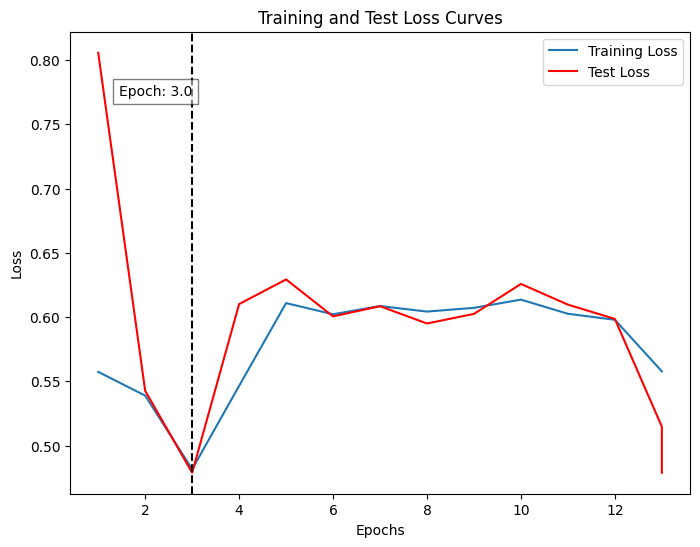

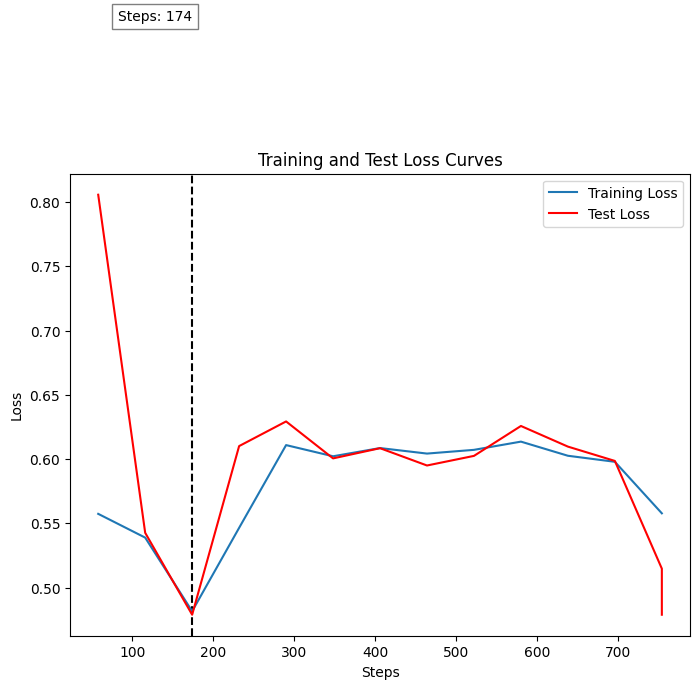

In [ ]:
# Extract loss values and steps
training_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
eval_loss = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]
steps = [log['step'] for log in trainer.state.log_history if 'loss' in log]
epochs = [log['epoch'] for log in trainer.state.log_history if 'loss' in log]

## epochs 

# Plotting
plt.figure(figsize=(8, 6))

# Plot training loss
plt.plot(epochs, training_loss, label='Training Loss')
eval_epochs = [log['epoch'] for log in trainer.state.log_history if 'eval_loss' in log]
plt.plot(eval_epochs, eval_loss, label='Test Loss', color='red')

epo_min = epoch_of_lowest_loss
plt.axvline(x=epo_min, linestyle ='--', color = 'k')
plt.text(epo_min, plt.ylim()[1] * 0.95, 'Epoch: {}'.format(epo_min),
         horizontalalignment='right', verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.5))


plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curves')
plt.legend()

plt.show()

## steps 

# Plotting
plt.figure(figsize=(8, 6))

# Since evaluation might occur less frequently, its steps need to be calculated separately
step_min = step_of_lowest_loss
plt.axvline(x=step_min, linestyle ='--', color = 'k')
plt.text(step_min, plt.ylim()[1] * 0.95, 'Steps: {}'.format(step_min),
         horizontalalignment='right', verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.5))

plt.plot(steps, training_loss, label='Training Loss')
eval_steps = [log['step'] for log in trainer.state.log_history if 'eval_loss' in log]
plt.plot(eval_steps, eval_loss, label='Test Loss', color='red')

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curves')
plt.legend()


plt.show()

## Model Predictions and Performance

In [ ]:
def compute_metrics_end(preds, refs):
  metric0 = evaluate.load("accuracy")
  metric1 = evaluate.load("precision")
  metric2 = evaluate.load("recall")
  metric3 = evaluate.load("f1")

  accuracy = metric0.compute(predictions=preds, references=refs)["accuracy"]
  precision = metric1.compute(predictions=preds, references=refs, average="weighted")["precision"]
  recall = metric2.compute(predictions=preds, references=refs, average="weighted")["recall"]
  f1 = metric3.compute(predictions=preds, references=refs, average="weighted")["f1"]

  return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [ ]:
# creating model predictions for the validation data
predictions_test = trainer.predict(dat_tokenized["test"])

  # choosing the prediction that has the highest probability
preds_test_test = np.argmax(predictions_test.predictions, axis=-1)

  # calculating the probabilities instead of logits from each
predictions_probabilities_test = tf.nn.softmax(predictions_test.predictions)

metrics_test = compute_metrics_end(preds=preds_test_test, refs=predictions_test.label_ids)

In [ ]:
import pandas as pd

data = {'Predicted Labels': ["female" if i == 0 else "male" for i in preds_test_test],
          'True Labels': ["female" if i == 0 else "male" for i in predictions_test.label_ids],
          'Misclassification': ["TRUE" if preds_test_test[i] == predictions_test.label_ids[i] else 'MISS' for i, test in enumerate(preds_test_test)],
          'Text': dat_tokenized['test']['text'],
          'Logit Values': [str(i) for i in predictions_test.predictions],
          'Probabilities': [str(i) for i in np.asarray(predictions_probabilities_test)]}


df_metrics_test = pd.DataFrame(metrics_test.items())




### Classification Report

In [ ]:
from sklearn.metrics import classification_report
### https://www.jcchouinard.com/classification-report-in-scikit-learn/
### classification repport to get support

classification_report(data['True Labels'], data['Predicted Labels'])

'              precision    recall  f1-score   support\n\n      female       0.70      0.60      0.65       133\n        male       0.85      0.90      0.87       328\n\n    accuracy                           0.81       461\n   macro avg       0.77      0.75      0.76       461\nweighted avg       0.81      0.81      0.81       461\n'

#### Saving model performance and metric:

In [ ]:
df_metrics_test = pd.DataFrame(metrics_test.items())

dat.to_csv("/content/drive/MyDrive/Colab_Notebooks/NLP_EX_COLAB/eval_outputs/NBL_df_classification_report.csv")
df_metrics_test.to_csv("/content/drive/MyDrive/Colab_Notebooks/NLP_EX_COLAB/eval_outputs/NBL_df_classification_metrics_test.csv")